In [2]:
 #Adversarial Attacks and Defenses in Speech Recognition Systems

In [ ]:
#Objective

#To analyze and improve the robustness of speech recognition systems 
#by studying the impact of adversarial attacks on audio inputs and 
#implementing effective defense mechanisms—such as pre-emphasis filtering and 
#adversarial training—to enhance transcription accuracy and 


In [ ]:
#Moto
#ensure the security of voice-based AI applications.

In [ ]:
# Step 1: Install Required Libraries

In [3]:
!pip install torchaudio transformers librosa jiwer -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Step 2: Load Sample from Dataset

In [7]:
import os
import pandas as pd
import librosa
import random
import IPython.display as ipd
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import numpy as np
from jiwer import wer
import matplotlib.pyplot as plt
import librosa.display
import torchaudio
import torch.nn as nn

In [8]:
folder_path ="D:\Project\dataset\cv-valid-train\cv-valid-train"
audio_file=os.listdir(folder_path )
print(f"Number of audio file: {len(audio_file)}")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\HariPriya\AppData\Local\Temp\ipykernel_6284\2884968016.py:1: SyntaxWarning: invalid escape sequence '\P'
  folder_path ="D:\Project\dataset\cv-valid-train\cv-valid-train"


Number of audio file: 195777


In [9]:
csv_path="cv-valid-train.csv"
df=pd.read_csv(csv_path)
print(f"Total number of samples: {len(df)}")

Total number of samples: 195776


In [83]:
sample=df.sample(1).iloc[0]
print(sample)

filename                       cv-valid-train/sample-178492.mp3
text          he listened to the wind and felt the stones be...
up_votes                                                      2
down_votes                                                    1
age                                                         NaN
gender                                                      NaN
accent                                                      NaN
duration                                                    NaN
Name: 178492, dtype: object


In [84]:
filename = os.path.basename(sample['filename'])
ground_truth = sample['text']
print(filename)
print(ground_truth)

sample-178492.mp3
he listened to the wind and felt the stones beneath his feet


In [85]:
file_path = os.path.join(folder_path, filename)

try:
    y, sr = librosa.load(file_path, sr=16000)
    print(f"Loaded {filename} successfully with sampling rate {sr}")
    print(f"Ground truth: {ground_truth}")
except Exception as e:
    print(f"Failed to load {filename}: {e}")

Loaded sample-178492.mp3 successfully with sampling rate 16000
Ground truth: he listened to the wind and felt the stones beneath his feet


In [39]:
#Step 3: Load Audio

In [86]:
y,sr=librosa.load(file_path,sr=16000)
ipd.Audio(y,rate=sr)

In [41]:
#Step 4: Load Pretrained Wav2Vec2 Model

In [87]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

inputs = processor(y, sampling_rate=sr, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)
original_transcript = processor.decode(predicted_ids[0])

print(" Original Transcription:", original_transcript)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Original Transcription: HE LISTENED TO THE WIND AND FELT THE STONES BENEATH HIS FEET


In [43]:
#Step 5: Simulate FGSM Adversarial Attack

In [88]:
def fgsm_attack(audio, epsilon=0.01):
    if isinstance(audio, np.ndarray):
        audio_tensor = torch.tensor(audio, dtype=torch.float32)
    else:
        audio_tensor = audio.clone().detach().float()

    audio_tensor = torch.clamp(audio_tensor, -1.0, 1.0)

    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)  
    audio_tensor = audio_tensor[:, :16000 * 10]  


    inputs = processor(audio_tensor.squeeze(), sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs["input_values"]
    input_values.requires_grad_()

    print("Input shape:", input_values.shape)

    try:
     
        outputs = model(input_values)
        logits = outputs.logits

        loss = logits.sum()
        loss.backward()


        if input_values.grad is not None:
            print("Gradients calculated successfully.")

            grad_sign = input_values.grad.sign()
            perturbed_input = input_values + epsilon * grad_sign

            perturbed_input = torch.clamp(perturbed_input, -1.0, 1.0)

            print("Grad shape:", input_values.grad.shape)
            print("Loss value:", loss.item())

            return perturbed_input.squeeze().detach().cpu().numpy()

        else:
            print("Gradients are still missing.")
            return None

    except Exception as e:
        print("Error during FGSM attack:", str(e))
        return None

perturbed_audio = fgsm_attack(y)

if perturbed_audio is not None:

    inputs_attacked = processor(perturbed_audio, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits_attacked = model(**inputs_attacked).logits
        predicted_ids = torch.argmax(logits_attacked, dim=-1)
        attack_transcript = processor.batch_decode(predicted_ids)[0]
        print("Adversarial Transcription:", attack_transcript)
else:
    print("FGSM attack failed again.")


Input shape: torch.Size([1, 69504])
Gradients calculated successfully.
Grad shape: torch.Size([1, 69504])
Loss value: -36532.65234375
Adversarial Transcription: HE LISTENED TO THE WIND AND FELT ASTONE BENEATH HIS FEET


In [89]:
if sr != 16000:
    import torchaudio
    import torchaudio.transforms as T
    resampler = T.Resample(sr, 16000)
    perturbed_audio_tensor = torch.tensor(perturbed_audio).unsqueeze(0)
    perturbed_audio_resampled = resampler(perturbed_audio_tensor).squeeze(0).numpy()
    sr = 16000
else:
    perturbed_audio_resampled = perturbed_audio


In [90]:
print("Type:", type(perturbed_audio))
print("Shape:", np.shape(perturbed_audio))
print("Min:", np.min(perturbed_audio), "Max:", np.max(perturbed_audio))

Type: <class 'numpy.ndarray'>
Shape: (69504,)
Min: -1.0 Max: 1.0


In [69]:
# Step 6: Apply Defense

In [91]:
if perturbed_audio is not None:
    defended_audio = librosa.effects.preemphasis(perturbed_audio)
    
    inputs_defended = processor(defended_audio, sampling_rate=sr, return_tensors="pt")
    logits_defended = model(**inputs_defended).logits
    predicted_ids = torch.argmax(logits_defended, dim=-1)
    defended_transcript = processor.batch_decode(predicted_ids)[0]

    print("\nDefended Transcription:\n", defended_transcript)
else:
    print("Error: perturbed_audio is None. FGSM attack might have failed.")



Defended Transcription:
 HE LISTENED TO THE WIND AND FELT A STONE BENEATH HIS FEET


In [71]:
# Step 7: WER Evaluation

In [92]:
print("Original Transcription:", original_transcript)
print("Adversarial Transcription:", attack_transcript)
print("Defended Transcription:", defended_transcript)
print("Ground Truth:", ground_truth)

from jiwer import wer


# Lowercase and strip
gt = ground_truth.lower().strip()
ot = original_transcript.lower().strip()
at = attack_transcript.lower().strip()
dt = defended_transcript.lower().strip()

# Call WER on full sentences
wer_orig = wer(gt, ot)
wer_attk = wer(gt, at)
wer_def = wer(gt, dt)

print(f"WER Original:  {wer_orig:.2f}")
print(f"WER Attacked:  {wer_attk:.2f}")
print(f"WER Defended:  {wer_def:.2f}")


Original Transcription: HE LISTENED TO THE WIND AND FELT THE STONES BENEATH HIS FEET
Adversarial Transcription: HE LISTENED TO THE WIND AND FELT ASTONE BENEATH HIS FEET
Defended Transcription: HE LISTENED TO THE WIND AND FELT A STONE BENEATH HIS FEET
Ground Truth: he listened to the wind and felt the stones beneath his feet
WER Original:  0.00
WER Attacked:  0.17
WER Defended:  0.17


In [73]:
# Step 8: Visualize Waveforms and Spectrograms

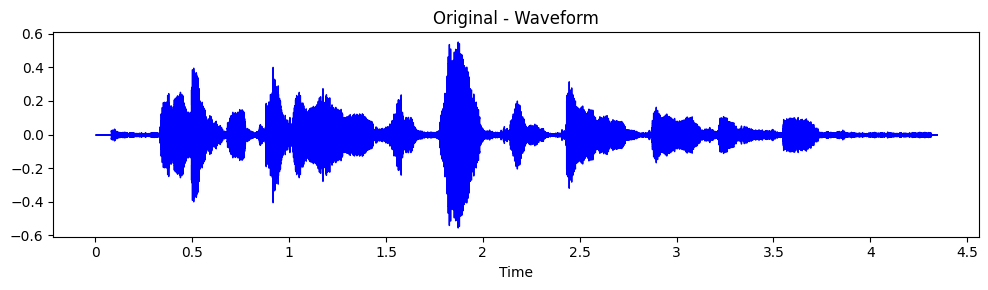

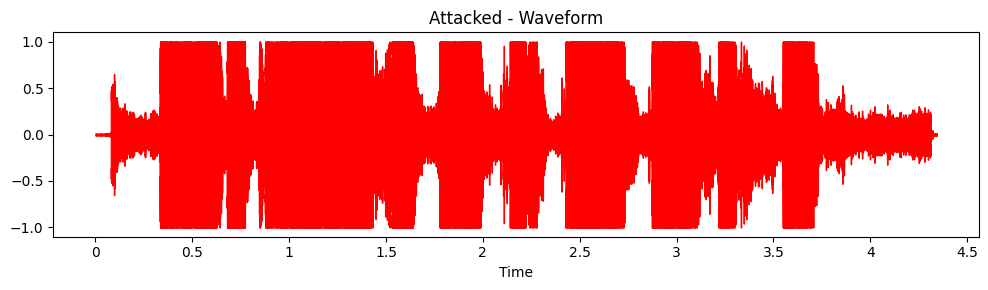

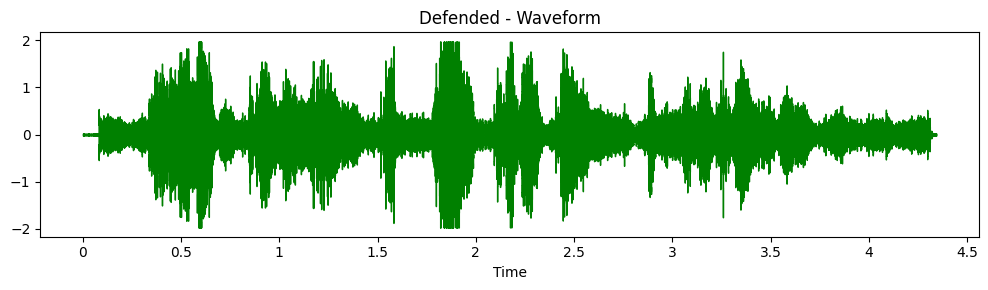

In [93]:
import matplotlib.pyplot as plt
import librosa.display

def plot_waveform(audio, title, color):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=16000, color=color)
    plt.title(f"{title} - Waveform")
    plt.tight_layout()
    plt.show()

plot_waveform(y, "Original", "blue")
plot_waveform(perturbed_audio, "Attacked", "red")
plot_waveform(defended_audio, "Defended", "green")

In [25]:
 #Step 9: WER Bar Chart

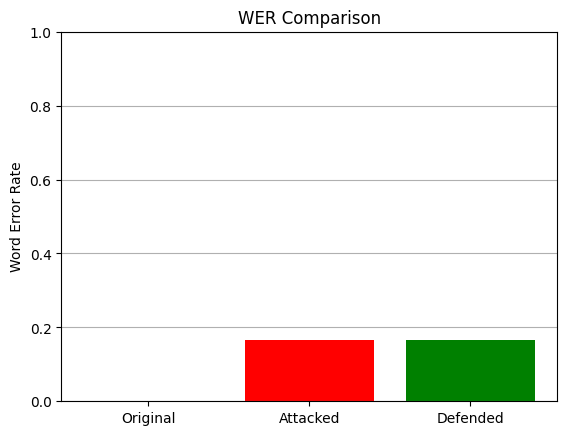

In [94]:
plt.bar(["Original", "Attacked", "Defended"], 
        [wer_orig, wer_attk, wer_def], 
        color=["blue", "red", "green"])
plt.ylabel("Word Error Rate")
plt.title("WER Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


In [76]:
#PGD attack

In [95]:
import torch
import numpy as np

def pgd_attack(audio, epsilon=0.01, alpha=0.001, num_iter=10):
    if isinstance(audio, np.ndarray):
        audio_tensor = torch.tensor(audio, dtype=torch.float32)
    else:
        audio_tensor = audio.clone().detach().float()

    audio_tensor = torch.clamp(audio_tensor, -1.0, 1.0)

    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)

    # Remove slicing for full audio, or keep if you want 5 sec
    audio_tensor = audio_tensor[:, :16000 * 10]

    inputs = processor(audio_tensor.squeeze(), sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs["input_values"]
    input_values.requires_grad = True

    print("Input shape:", input_values.shape)

    perturbed_input = input_values.clone().detach()

    try:
        for i in range(num_iter):
            perturbed_input.requires_grad_()
            perturbed_input.retain_grad()


            outputs = model(perturbed_input)
            logits = outputs.logits

            loss = logits.sum()
            model.zero_grad()
            #loss.backward()
            loss.backward(retain_graph=True)


            if perturbed_input.grad is not None:
                grad_sign = perturbed_input.grad.sign()
                perturbed_input = perturbed_input + alpha * grad_sign

                # Project back into epsilon ball
                perturbation = torch.clamp(perturbed_input - input_values, min=-epsilon, max=epsilon)
                perturbed_input = input_values + perturbation

                # Clamp final values to audio range
                perturbed_input = torch.clamp(perturbed_input, -1.0, 1.0)

                print(f"Iteration {i+1}/{num_iter} - Loss: {loss.item()}")
            else:
                print("Gradients missing at iteration", i+1)
                break

        return perturbed_input.squeeze().detach().cpu().numpy()

    except Exception as e:
        print("Error during PGD attack:", str(e))
        return None

# Apply PGD attack
perturbed_audio = pgd_attack(y, epsilon=0.01, alpha=0.001, num_iter=10)

if perturbed_audio is not None:
    inputs_attacked = processor(perturbed_audio, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits_attacked = model(**inputs_attacked).logits
        predicted_ids = torch.argmax(logits_attacked, dim=-1)
        attack_transcript = processor.batch_decode(predicted_ids)[0]
        print("Adversarial Transcription:", attack_transcript)
else:
    print("PGD attack failed.")


Input shape: torch.Size([1, 69504])
Iteration 1/10 - Loss: -36532.65234375
Iteration 2/10 - Loss: -33150.66796875
Iteration 3/10 - Loss: -32494.95703125
Iteration 4/10 - Loss: -31626.6953125
Iteration 5/10 - Loss: -30590.39453125
Iteration 6/10 - Loss: -30076.6640625
Iteration 7/10 - Loss: -29827.091796875
Iteration 8/10 - Loss: -29365.73828125
Iteration 9/10 - Loss: -29193.509765625
Iteration 10/10 - Loss: -28423.615234375
Adversarial Transcription: HE LITENED TOUG THE WING AND FALTS A TINLY PINGS HIS FEET


In [96]:
if sr != 16000:
    import torchaudio
    import torchaudio.transforms as T
    resampler = T.Resample(sr, 16000)
    perturbed_audio_tensor = torch.tensor(perturbed_audio).unsqueeze(0)
    perturbed_audio_resampled = resampler(perturbed_audio_tensor).squeeze(0).numpy()
    sr = 16000
else:
    perturbed_audio_resampled = perturbed_audio


In [97]:
print("Type:", type(perturbed_audio))
print("Shape:", np.shape(perturbed_audio))
print("Min:", np.min(perturbed_audio), "Max:", np.max(perturbed_audio))

Type: <class 'numpy.ndarray'>
Shape: (69504,)
Min: -1.0 Max: 1.0


In [31]:
#Defense

In [98]:
if perturbed_audio is not None:
    defended_audio = librosa.effects.preemphasis(perturbed_audio)
    
    inputs_defended = processor(defended_audio, sampling_rate=sr, return_tensors="pt")
    logits_defended = model(**inputs_defended).logits
    predicted_ids = torch.argmax(logits_defended, dim=-1)
    defended_transcript = processor.batch_decode(predicted_ids)[0]

    print("\nDefended Transcription:\n", defended_transcript)
else:
    print("Error: perturbed_audio is None. FGSM attack might have failed.")



Defended Transcription:
 HE LISTENED TO THE WIND AND FELT O STONE TINGS HIS FEET


In [99]:
print("Original Transcription:", original_transcript)
print("Adversarial Transcription:", attack_transcript)
print("Defended Transcription:", defended_transcript)
print("Ground Truth:", ground_truth)

# Lowercase and strip
gt = ground_truth.lower().strip()
ot = original_transcript.lower().strip()
at = attack_transcript.lower().strip()
dt = defended_transcript.lower().strip()

# Call WER on full sentences
wer_orig = wer(gt, ot)
wer_attk = wer(gt, at)
wer_def = wer(gt, dt)

print(f"WER Original:  {wer_orig:.2f}")
print(f"WER Attacked:  {wer_attk:.2f}")
print(f"WER Defended:  {wer_def:.2f}")


Original Transcription: HE LISTENED TO THE WIND AND FELT THE STONES BENEATH HIS FEET
Adversarial Transcription: HE LITENED TOUG THE WING AND FALTS A TINLY PINGS HIS FEET
Defended Transcription: HE LISTENED TO THE WIND AND FELT O STONE TINGS HIS FEET
Ground Truth: he listened to the wind and felt the stones beneath his feet
WER Original:  0.00
WER Attacked:  0.58
WER Defended:  0.25


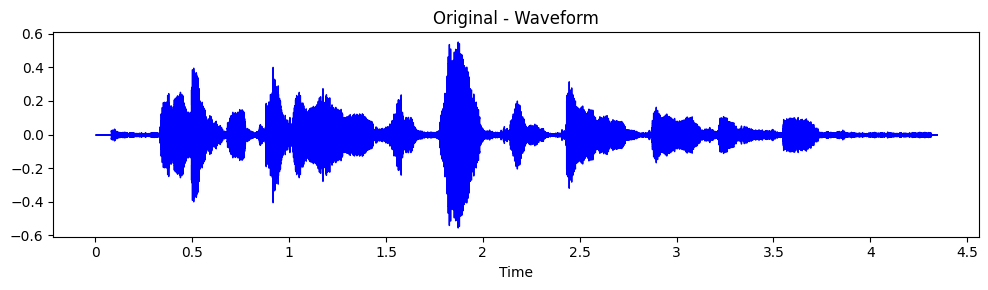

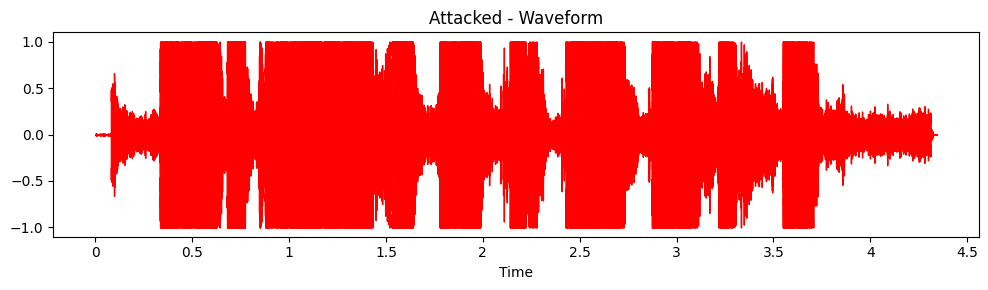

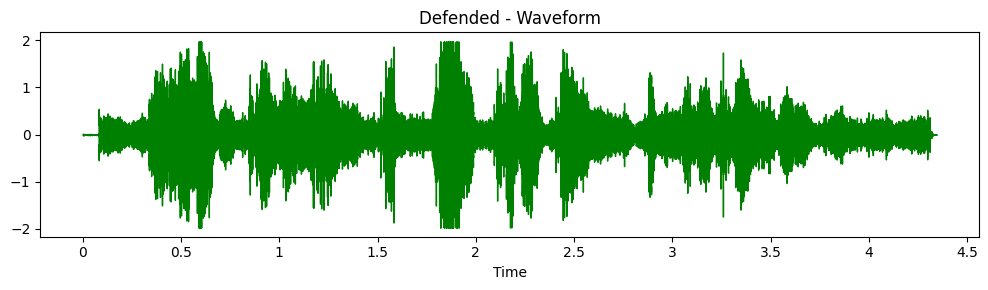

In [100]:
import matplotlib.pyplot as plt
import librosa.display

def plot_waveform(audio, title, color):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=16000, color=color)
    plt.title(f"{title} - Waveform")
    plt.tight_layout()
    plt.show()

plot_waveform(y, "Original", "blue")
plot_waveform(perturbed_audio, "Attacked", "red")
plot_waveform(defended_audio, "Defended", "green")

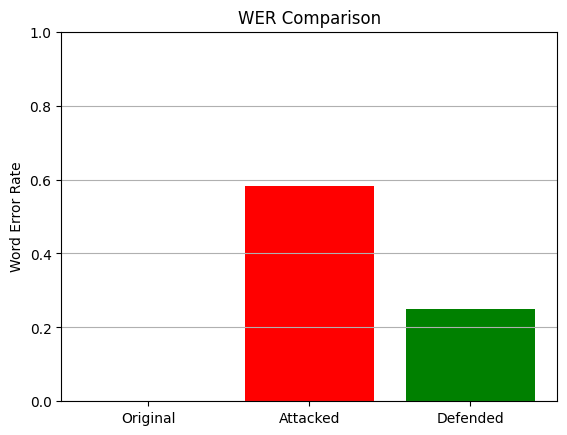

In [101]:
plt.bar(["Original", "Attacked", "Defended"], 
        [wer_orig, wer_attk, wer_def], 
        color=["blue", "red", "green"])
plt.ylabel("Word Error Rate")
plt.title("WER Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()
